In [1]:
import numpy as np
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load Graphs
If you do not have these two graph files, run the `create_wow_graph.py` python script.

In [2]:
# Load graphs
G = nx.read_gexf('./saved_graphs/G_wow.gexf')
Gcc = nx.read_gexf('./saved_graphs/Gcc_wow.gexf')

# get the undirected version of the GCC
Gcc_u = Gcc.to_undirected().copy()

# get node and edge lists of Gcc
node_list = np.array(list(Gcc.nodes))
edge_list = np.array(list(Gcc.edges))

# print quick info
print(f'\t\tG\tGcc')
print(f"# of nodes:\t{len(list(G.nodes))}\t{len(node_list)}")
print(f"# of links:\t{len(list(G.edges))}\t{len(edge_list)}")

		G	Gcc
# of nodes:	264	261
# of links:	4006	4005


# Degree Distributions

In [3]:
# Get arrays of total, out- and in-degrees
tot_deg = np.array([v for _, v in Gcc.degree])
out_deg = np.array([v for _, v in Gcc.out_degree])
in_deg = np.array([v for _, v in Gcc.in_degree])

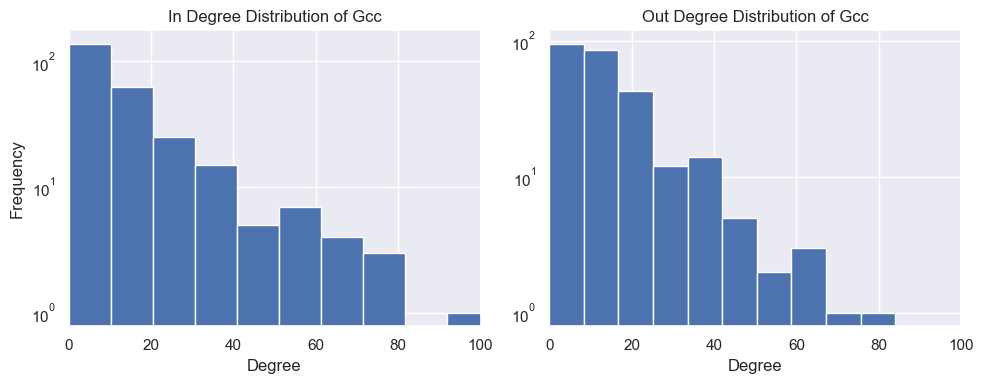

In [4]:
# Create histograms of in and out degree distributions
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(in_deg, bins=10)
ax[1].hist(out_deg, bins=10)

ax[0].set_title('In Degree Distribution of Gcc')
ax[1].set_title('Out Degree Distribution of Gcc')

ax[0].set_ylabel('Frequency')
ax[1].set_yticks([])
for i in range(2):
    ax[i].set_xlabel('Degree')
    ax[i].set_yscale('log')
    ax[i].set_xlim([0, 100])
plt.tight_layout()
plt.savefig('./visualizations/degree_distributions.png')
plt.savefig('./visualizations/degree_distributions_trans.png', transparent=True)
plt.show()

In [5]:
# display top characters in regards to total-, out- and in-degree
print('Top five characters according to')
print(f'Total degree:\t{", ".join(node_list[np.argsort(tot_deg)[::-1][:5]])}')
print(f'Out degree:\t{", ".join(node_list[np.argsort(out_deg)[::-1][:5]])}')
print(f'In degree:\t{", ".join(node_list[np.argsort(in_deg)[::-1][:5]])}')

# display bottom characters in regards to total-, out- and in-degree
print('\nBottom five characters according to')
print(f'Total degree:\t{", ".join(node_list[np.argsort(tot_deg)[:5]])}')
print(f'Out degree:\t{", ".join(node_list[np.argsort(out_deg)[:5]])}')
print(f'In degree:\t{", ".join(node_list[np.argsort(in_deg)[:5]])}')

Top five characters according to
Total degree:	Thrall, Sylvanas Windrunner, Jaina Proudmoore, Anduin Wrynn, Varian Wrynn
Out degree:	Thrall, Jaina Proudmoore, Sylvanas Windrunner, Varian Wrynn, Anduin Wrynn
In degree:	Thrall, Sylvanas Windrunner, Lich King, Jaina Proudmoore, Deathwing

Bottom five characters according to
Total degree:	Silas Darkmoon, Baron Revilgaz, Liu Lang, Grand Empress Shek'zeer, Kang
Out degree:	Baron Revilgaz, Liu Lang, Silas Darkmoon, Smolderon, Grand Empress Shek'zeer
In degree:	The Monkey King, Silas Darkmoon, Mogor, Master Apothecary Faranell, Grand Empress Shek'zeer


# Attribute Distributions

In [11]:
# get distribution of all attributes
attr_names = ['gender', 'faction', 'status', 'race']
f, ax = plt.subplots(len(attr_names), 1, figsize=(30, 30))
for i, aname in enumerate(attr_names):
    attr_list = np.array(list(nx.get_node_attributes(Gcc, aname).values()))
    attr_keys, attr_counts = np.unique(attr_list, return_counts=True)
    ax[i].set_title(f'{aname} distribution'.title(), fontsize=20)
    ax[i].bar(attr_keys, attr_counts)
    ax[i].set_ylabel('count', fontsize=14)

    if aname == 'race':
        xlabel_rotation = 90
    else:
        xlabel_rotation = 0
    plt.setp(ax[i].get_xticklabels(), fontsize=14, rotation=xlabel_rotation)
    plt.setp(ax[i].get_yticklabels(), fontsize=14)
plt.savefig('./visualizations/attribute_distributions.png')
plt.savefig('./visualizations/attribute_distributions_trans.png', transparent=True)
plt.show()

# Network Visualization
On the undirected version of the network

In [7]:
# get nodes and edges with data
node_data = Gcc_u.nodes(data=True)
edge_data = Gcc_u.edges(data=True)

# determine node size in regards to degree of node
node_sizes = [2*v for v in dict(Gcc_u.degree).values()]

# create node color list depending on faction
node_colors = []
for _, attr in list(node_data):
    fac = attr['faction']
    if fac == 'Horde':
        node_colors.append('#FF3333')
    elif fac == 'Alliance':
        node_colors.append('#3399FF')
    else:
        node_colors.append('#A0A0A0')

# create edge color list depending on faction of the two connecting nodes
edge_colors = []
for n1, n2, _ in list(edge_data):
    f1 = node_data[n1]['faction']
    f2 = node_data[n2]['faction']

    if f1 == 'Alliance':
        if f2 == 'Alliance':
            edge_colors.append('#3399FF')
        elif f2 == 'Horde':
            edge_colors.append('#005700')
        else:
            edge_colors.append('#A0A0A0')
    elif f1 == 'Horde':
        if f2 == 'Alliance':
            edge_colors.append('#005700')
        elif f2 == 'Horde':
            edge_colors.append('#FF3333')
        else:
            edge_colors.append('#A0A0A0')
    else:
        edge_colors.append('#A0A0A0')

In [8]:
# Setup FA2 w. parameters
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,    # Dissuade hubs
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=True,
    gravity=1,

    # Log
    verbose=False
)

# compute node positions with the fa algorithm
node_pos = forceatlas2.forceatlas2_networkx_layout(Gcc_u, pos=None, iterations=2000)

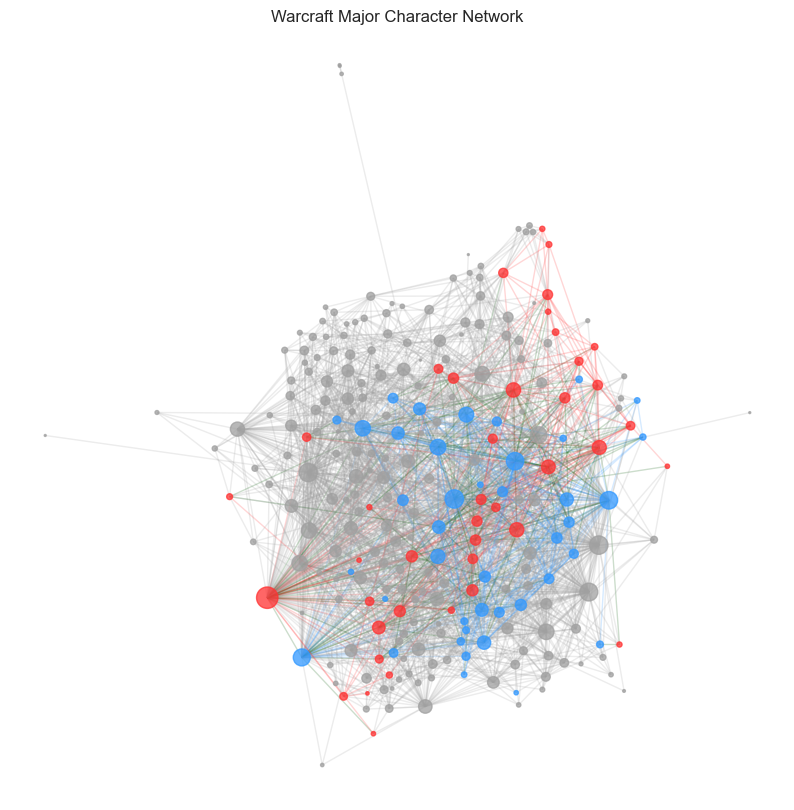

In [9]:
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(Gcc_u, node_pos, node_size=node_sizes, node_color=node_colors, alpha=0.75)
nx.draw_networkx_edges(Gcc_u, node_pos, edge_color=edge_colors, alpha=0.2)
plt.title('Warcraft Major Character Network')
plt.axis('off')
plt.savefig('./visualizations/network.png')
plt.savefig('./visualizations/network_trans.png', transparent=True)
plt.show()